### Azure Machine Learning Service Framework

#### Set up Development Environment

Initialize Workspace
- Import base Azure ML packages
- Check the SDK version
- Connect to the workspace

#### Set up: Initialize the Workspace

In [1]:
# base packages to work with AMLS
import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Ready to use Azure ML", azureml.core.VERSION)

Ready to use Azure ML 1.18.0


In [4]:
SUBSCRIPTION_ID='79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5' # provide your subscription ID
RESOURCE_GROUP_NAME  = 'unive-resource-group' # provide a resource group name
WORKSPACE_NAME  = 'unive-workspace' # provide a name for your workspace
REGION = 'westeurope' # For example: 'westeurope' or 'eastus2' or 'westus2' or 'southeastasia'.

ws = None
try:
    # Find existing workspace
    ws = Workspace(workspace_name=WORKSPACE_NAME,
                   subscription_id=SUBSCRIPTION_ID,
                   resource_group= RESOURCE_GROUP_NAME)
    print (ws.name, "found.")
except Exception as ex:
    # If workspace not found, create it
    print(ex.message)
    print("Attempting to create new workspace...")
    ws = Workspace.create(name=WORKSPACE_NAME, 
                          subscription_id=SUBSCRIPTION_ID,
                          resource_group=RESOURCE_GROUP_NAME,
                          create_resource_group=True,
                          location=REGION)
    print(ws.name, "created.")
finally:
    # Save the workspace configuration for later
    if ws != None:
        # write out the workspace details to a configuration file: .azureml/config.json
        ws.write_config(path='.azureml')
        print(ws.name, "saved.")

get_workspace error using subscription_id=79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5, resource_group_name=unive-resource-group, workspace_name=unive-workspace


Workspace not found.
Attempting to create new workspace...


Deploying KeyVault with name univeworkeyvault8b2e4c6f.
Deploying StorageAccount with name univeworstorage4bcd40317.
Deploying AppInsights with name univeworinsightsfba2ddd7.
Deployed AppInsights with name univeworinsightsfba2ddd7. Took 5.49 seconds.
Deployed KeyVault with name univeworkeyvault8b2e4c6f. Took 20.04 seconds.
Deploying Workspace with name unive-workspace.
Deployed StorageAccount with name univeworstorage4bcd40317. Took 22.83 seconds.
Deployed Workspace with name unive-workspace. Took 20.92 seconds.
unive-workspace created.
unive-workspace saved.


In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code CQQ4VAUEG to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.
unive-workspace	westeurope	unive-resource-group	westeurope


#### Set up: create compute

In [3]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

ws = Workspace.from_config() # This automatically looks for a directory .azureml
CPU_CLUSTER_NAME = "cpu-cluster" # Choose a name for your CPU cluster

# Verify that the cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=CPU_CLUSTER_NAME)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_D1_v2',
                                                            min_nodes = 1,
                                                            max_nodes=2, #will autoscale between zero and two nodes
                                                            idle_seconds_before_scaledown=300)
    cpu_cluster = ComputeTarget.create(ws, CPU_CLUSTER_NAME, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

Creating
Succeeded.......................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


#### Set up: upload data to datastore

In [4]:
# Get the default datastore
default_ds = ws.get_default_datastore()

# Enumerate all datastores, indicating which is the default
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == default_ds.name) # workspaceblobstore <- Default

# Adult Census Income Binary classfication dataset
default_ds.upload_files(files=['./data/adult.csv'], # Upload the data/adults.csv file
                       target_path='adults-data/', # Put it in a folder path in the datastore
                       overwrite=True, # Replace existing files of the same name
                       show_progress=True)

workspaceblobstore - Default = True
workspacefilestore - Default = False
Uploading an estimated of 1 files
Uploading ./data/adult.csv
Uploaded ./data/adult.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_85c9d712a8d04f229f8411000b2d97b8

#### Initialize an Experiment

In [5]:
# Name your experiment here.
experiment_name = 'experiment-1-adult-SVC'

from azureml.core import Experiment
experiment = Experiment(workspace=ws, name=experiment_name)
print(f"Experiment: {experiment.name}")

Experiment: experiment-1-adult-SVC


In [6]:
# Directory to write training script.
# Code Directory
import os
script_folder = os.path.join(os.getcwd(), "script")
os.makedirs(script_folder, exist_ok=True)

#### Dataset

This is also the folder where we’ll want to write out any file outputs (training, scoring, YAML,etc.)

In [7]:
from azureml.core import Dataset

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

#Create a tabular dataset from the path on the datastore (this may take a short while)
data_set = Dataset.Tabular.from_delimited_files(path=(ds, 'adults-data/adult.csv'))

# Display the first 20 rows as a Pandas dataframe
data_set.take(4).to_pandas_dataframe()

AzureBlob univeworstorage4bcd40317 azureml-blobstore-d5af5167-804c-41a6-bae2-8631f76e6de9


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K


In [8]:
# Register the dataset
dataset_name = 'Dataset-adults'
data_set = data_set.register(workspace=ws, 
                           name=dataset_name,
                           description='UCI Adult Dataset (1994 Census)',
                           tags = {'year':'1994', 'category':'Census Income'},
                           create_new_version=True)

# List the datasets registered in the workspace
for ds in ws.datasets:
    print(ds)

Dataset-adults


#### Setup: create a python environment

In [9]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

# Create a Python environment
adults_env = Environment("adults-env")
#adults_env.python.user_managed_dependencies = False # we're going to create a custom environment
adults_env.docker.enabled = True # we use a docker container (default is true)

# Create a set of package dependencies (conda or pip as required)
adults_conda = CondaDependencies.create(conda_packages=['pandas','numpy','scikit-learn','joblib','ipykernel','matplotlib','lightgbm'],
                                          pip_packages=['azureml-sdk','argparse','pyarrow','mlxtend'])


# Add the dependencies to the environment
adults_env.python.conda_dependencies = adults_conda
adults_env.python.conda_dependencies.save_to_file(".", "adults-env.yml")
adults_env.register(workspace=ws)

print(f"List of existing environments:" )
for name,env in ws.environments.items():
    print("Name {} \t version {}".format(name,env.version))

List of existing environments:
Name adults-env 	 version 1
Name AzureML-AutoML 	 version 48
Name AzureML-PyTorch-1.0-GPU 	 version 43
Name AzureML-Scikit-learn-0.20.3 	 version 42
Name AzureML-TensorFlow-1.12-CPU 	 version 41
Name AzureML-PyTorch-1.2-GPU 	 version 43
Name AzureML-TensorFlow-2.0-GPU 	 version 41
Name AzureML-TensorFlow-2.0-CPU 	 version 40
Name AzureML-Chainer-5.1.0-GPU 	 version 43
Name AzureML-TensorFlow-1.13-CPU 	 version 42
Name AzureML-Minimal 	 version 43
Name AzureML-Chainer-5.1.0-CPU 	 version 42
Name AzureML-PyTorch-1.4-GPU 	 version 33
Name AzureML-PySpark-MmlSpark-0.15 	 version 38
Name AzureML-PyTorch-1.3-CPU 	 version 38
Name AzureML-PyTorch-1.1-GPU 	 version 43
Name AzureML-TensorFlow-1.10-GPU 	 version 43
Name AzureML-PyTorch-1.2-CPU 	 version 42
Name AzureML-TensorFlow-1.13-GPU 	 version 43
Name AzureML-TensorFlow-1.10-CPU 	 version 42
Name AzureML-PyTorch-1.3-GPU 	 version 40
Name AzureML-PyTorch-1.4-CPU 	 version 33
Name AzureML-Tutorial 	 version 59
N

#### Training the model

Three steps involved in training and executing an experiment in the Azure ML Service:

1. Create the Training Script

For this code to work inside of the Azure ML service, the last few lines that output the pickle file are mandatory. The pickle file is what is used to register the Model inside of the Azure ML service.

In [18]:
%%writefile $script_folder/train_adult_SVC.py
import os
import argparse
import joblib
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from azureml.core import Workspace, Dataset, Experiment, Run
import matplotlib.pyplot as plt

# Get the experiment run context
run = Run.get_context()

# load the diabetes dataset
dataset_name = 'Dataset-adults'
print("Loading data from " + dataset_name)
#Adult Census Income Binary classfication dataset
df = Dataset.get_by_name(workspace=run.experiment.workspace, name=dataset_name).to_pandas_dataframe()

le = LabelEncoder()
new_df = df.loc[:, ~df.columns.isin(['workclass','occupation','native-country'])]
new_df.loc[:,'education'] = le.fit_transform(new_df.loc[:,'education'].values)
new_df.loc[:,'marital-status'] = le.fit_transform(new_df.loc[:,'marital-status'].values)
new_df.loc[:,'relationship'] = le.fit_transform(new_df.loc[:,'relationship'].values)
new_df.loc[:,'race'] = le.fit_transform(new_df.loc[:,'race'].values)
new_df.loc[:,'sex'] = le.fit_transform(new_df.loc[:,'sex'].values)
new_df.loc[:,'income'] = le.fit_transform(new_df.loc[:,'income'].values)

X = new_df.drop('income', axis=1).values
y = new_df['income'].values

#use stratify for un balanced number of examples for each class label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
    
# Model Training: Support Vector Machines
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

MODEL = 'SVC'
model = make_pipeline(StandardScaler(), 
                      SVC(kernel = 'rbf', C = 0.001, probability = True, 
                          max_iter = 1000, random_state = 42))

model.fit(X_train, y_train)
print(f"model: {model}")

# Evaluate the model

# using threshold
threshold = 0.5 # set threshold as 0.5
y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(int) 
print(f"y_pred: {y_pred}")
run.log('y_pred:', y_pred)

print(f'Misclassified examples:{(y_test != y_pred).sum()}')
run.log('Misclassified examples:', (y_test != y_pred).sum())

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")
run.log('confusion matrix:', conf_mat)

# AUC
auc = metrics.roc_auc_score(y_test, y_pred)
print(f"auc: {auc}")
run.log('auc:', auc)

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 
run.log('Accuracy:', accuracy)

# Precision
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision: {precision}")
run.log('Precision:', precision )

# Recall
recall = metrics.recall_score(y_test, y_pred)
print(f"Recall: {recall}")
run.log('Recall:', recall)

# F1
f1 = metrics.f1_score(y_test, y_pred)
print(f"F1: {f1}")
run.log('F1:', f1)

# classification_report
print('classification_report')
print(metrics.classification_report(y_test, y_pred))
run.log('classification_report', metrics.classification_report(y_test, y_pred))

# Save model
print('Exported model: adult_SVC.pkl')
f = open('adult_SVC.pkl', 'wb')
pickle.dump(model, f)
f.close()

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/adult_SVC.pkl')


# save Graphs
# Graph 1
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
run.log_image('conf_mat', plot=plt)

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-compute-ds1v2/code/Users/877159/script/train_adult_SVC.py


2. Submit the Training Job to the Compute Cluster

When this code section completes, an Experiment will show up in the Azure portal in your Azure ML workspace resource. Also, assuming your Experiment has a pickle file output, that file is created here.

In [19]:
from azureml.core.compute import AmlCompute
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import DEFAULT_CPU_IMAGE

# Create a script config
src = ScriptRunConfig(source_directory=script_folder, script='train_adult_SVC.py')

compute_target = None
for compute_name  in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
# Set compute target to the one created in previous step
src.run_config.target = compute_target
print(f"compute_target: {compute_target}")

# Set environment
adults_env = ws.environments["adults-env"] 
src.run_config.environment = adults_env
 
run = experiment.submit(config=src)
run

found compute target: cpu-cluster
compute_target: AmlCompute(workspace=Workspace.create(name='unive-workspace', subscription_id='79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5', resource_group='unive-resource-group'), name=cpu-cluster, id=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourceGroups/unive-resource-group/providers/Microsoft.MachineLearningServices/workspaces/unive-workspace/computes/cpu-cluster, type=AmlCompute, provisioning_state=Succeeded, location=westeurope, tags=None)


Experiment,Id,Type,Status,Details Page,Docs Page
experiment-1-adult-SVC,experiment-1-adult-SVC_1606177239_ab471e0f,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


And we can watch the execution of the Training with the following code.


In [20]:
%%time
# specify show_output to True for a verbose log
run.wait_for_completion(show_output=True)

RunId: experiment-1-adult-SVC_1606177239_ab471e0f
Web View: https://ml.azure.com/experiments/experiment-1-adult-SVC/runs/experiment-1-adult-SVC_1606177239_ab471e0f?wsid=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourcegroups/unive-resource-group/workspaces/unive-workspace

Execution Summary
RunId: experiment-1-adult-SVC_1606177239_ab471e0f
Web View: https://ml.azure.com/experiments/experiment-1-adult-SVC/runs/experiment-1-adult-SVC_1606177239_ab471e0f?wsid=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourcegroups/unive-resource-group/workspaces/unive-workspace

CPU times: user 35.8 ms, sys: 3.97 ms, total: 39.7 ms
Wall time: 243 ms


{'runId': 'experiment-1-adult-SVC_1606177239_ab471e0f',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-11-24T00:20:50.959968Z',
 'endTimeUtc': '2020-11-24T00:22:14.403419Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '3f38a10e-3ffa-4d42-9c10-dbb6b964920c',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'e17f906f-60a7-4254-a7b7-344164fcd67e'}, 'consumptionDetails': {'type': 'Reference'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'train_adult_SVC.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpu-cluster',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'priority': None,
  'environment': {'name': 'adults-env',
   'versio

3. Register the Model

Registers the output pickle file in the Azure ML service workspace. Once this code completes, a Model will show up in the Azure portal.

In [21]:
# register model 
model = run.register_model(model_name='model-adult', model_path='outputs/adult_SVC.pkl')
print(model.name, model.id, model.version, sep='\t')

model-adult	model-adult:2	2


4. Download the model

In [22]:
# download model
import os 
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model=Model(ws, 'model-adult')
model.download(target_dir=os.path.join(os.getcwd(), "model"), exist_ok=True)

# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "model/adult_SVC.pkl")
print(f"file path: {file_path}")
os.stat(file_path)

file path: /mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-compute-ds1v2/code/Users/877159/model/adult_SVC.pkl


os.stat_result(st_mode=33279, st_ino=17293919326125948928, st_dev=46, st_nlink=1, st_uid=0, st_gid=0, st_size=218137, st_atime=1606175027, st_mtime=1606178118, st_ctime=1606178118)

X_train.shape: (22792, 11)
y_train.shape: (22792,)
X_test.shape: (9769, 11)
y_test.shape: (9769,)
/azureml-envs/azureml_72efb94fba8b2a327b62eea6d5035300/lib/python3.6/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.001, max_iter=1000, probability=True,
                     random_state=42))])
y_pred: [0 0 0 ... 0 0 1]
Misclassified examples:2172
confusion matrix:
 [[7427   28]
 [2144  170]]
auc: 0.5348549957190565
Accuracy: 0.7776640393080152
Precision: 0.8585858585858586
Recall: 0.07346585998271392
F1: 0.13535031847133758
classification_report
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7455
           1       0.86      0.07      0.14      2314

    accuracy                           0.78      9769
   macro avg       0.82      0.53      0.50      9769
weighted avg       0.80      0.78      0.70      9769

Exported model: adult_SVC.pkl

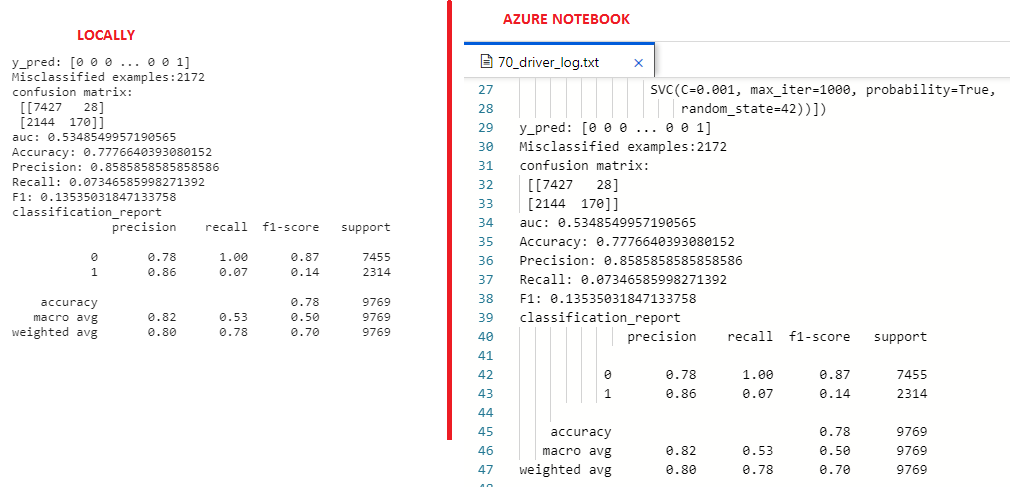

In [21]:
from IPython.display import Image
Image(filename='images/Azure/Exp-2/SVC/result.png')

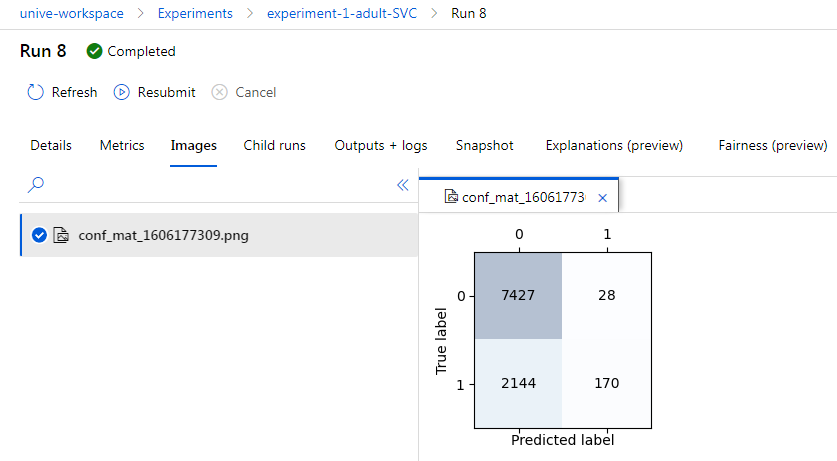

In [1]:
Image(filename='images/Azure/Exp-2/SVC/conf_mat.png')

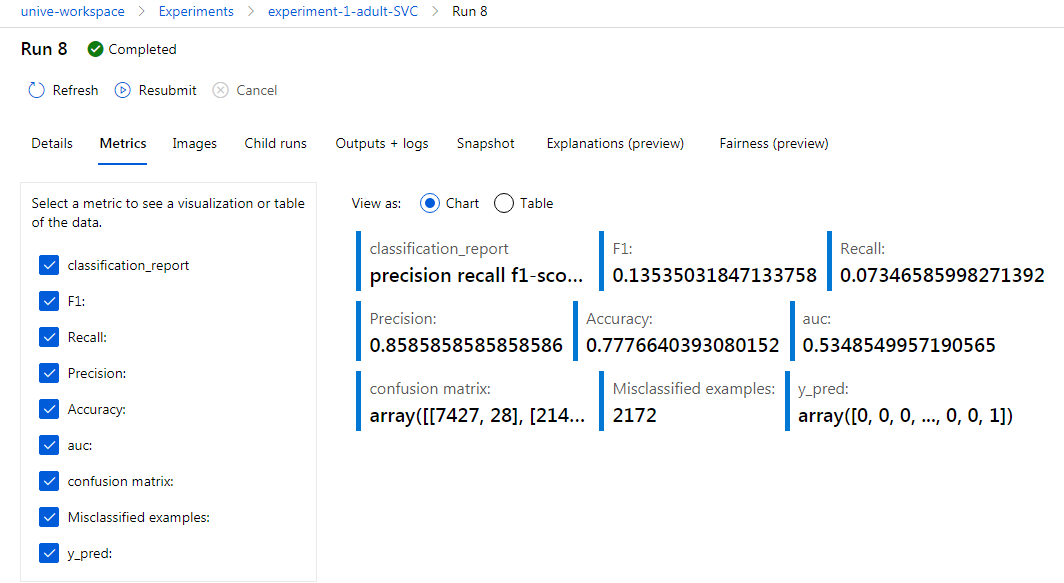

In [3]:
Image(filename='images/Azure/Exp-2/SVC/metrics.png')

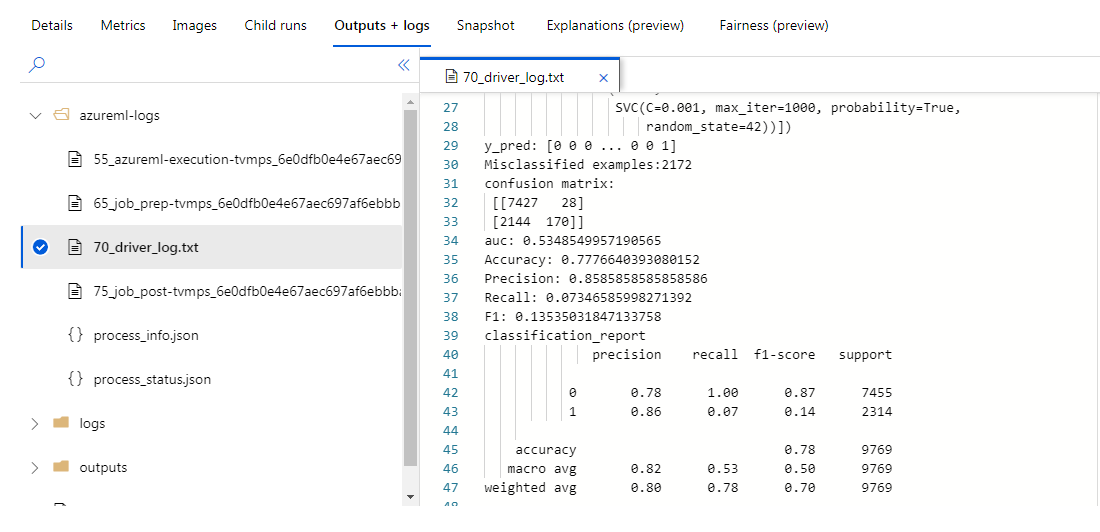

In [4]:
Image(filename='images/Azure/Exp-2/SVC/driver_log.png')
# sklearn.version:0.23.2

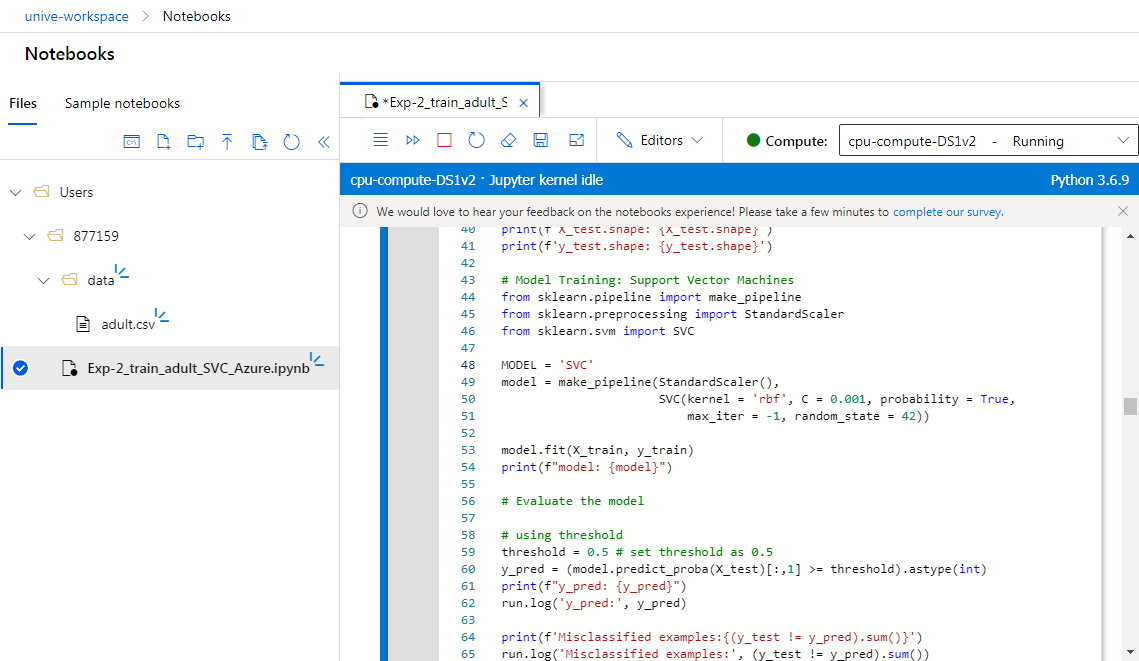

In [6]:
Image(filename='images/Azure/Exp-2/SVC/Notebook.png')

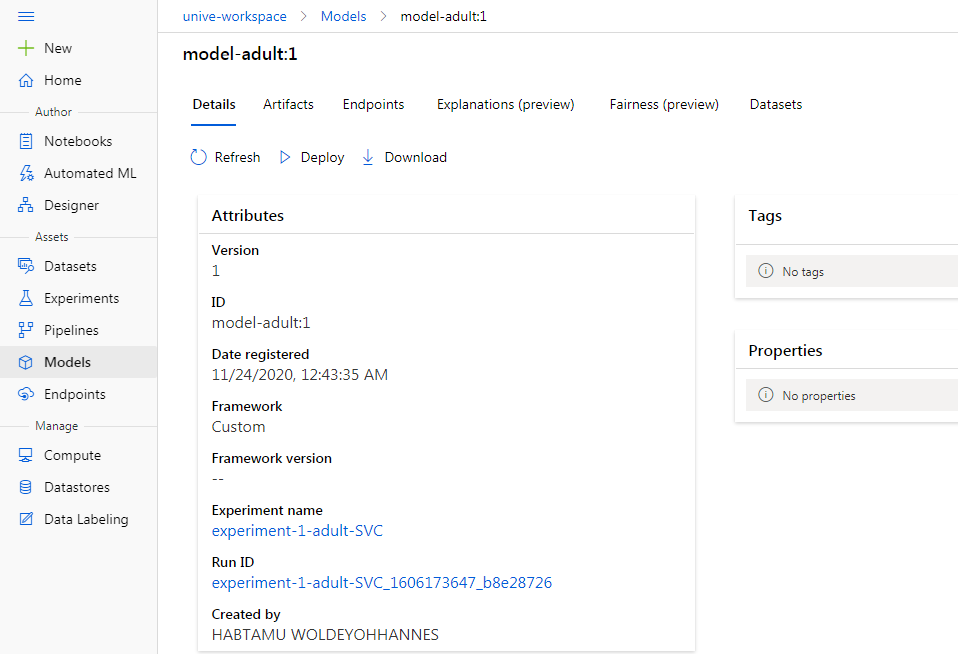

In [8]:
Image(filename='images/Azure/Exp-2/SVC/Model-1.png')

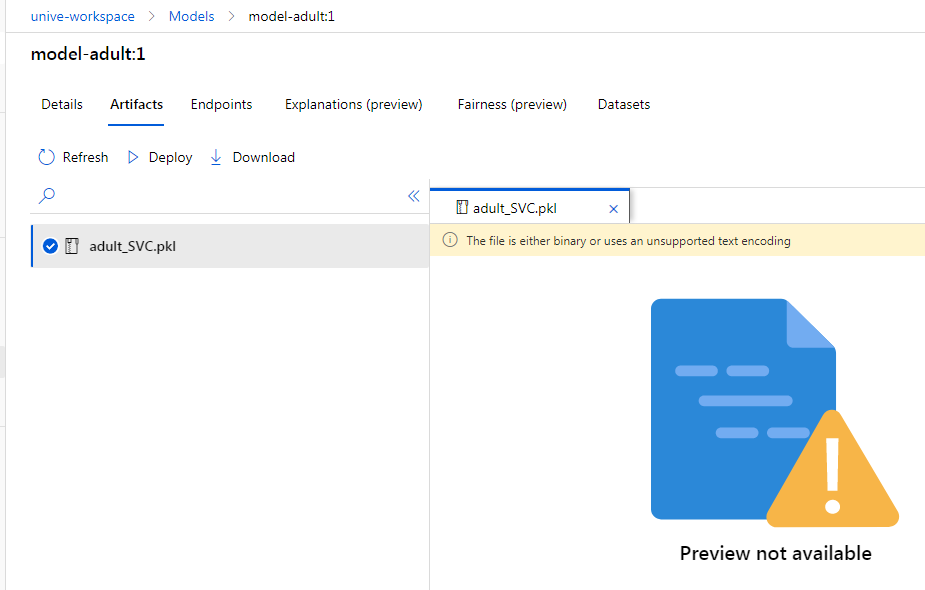

In [9]:
Image(filename='images/Azure/Exp-2/SVC/Model-download.png')

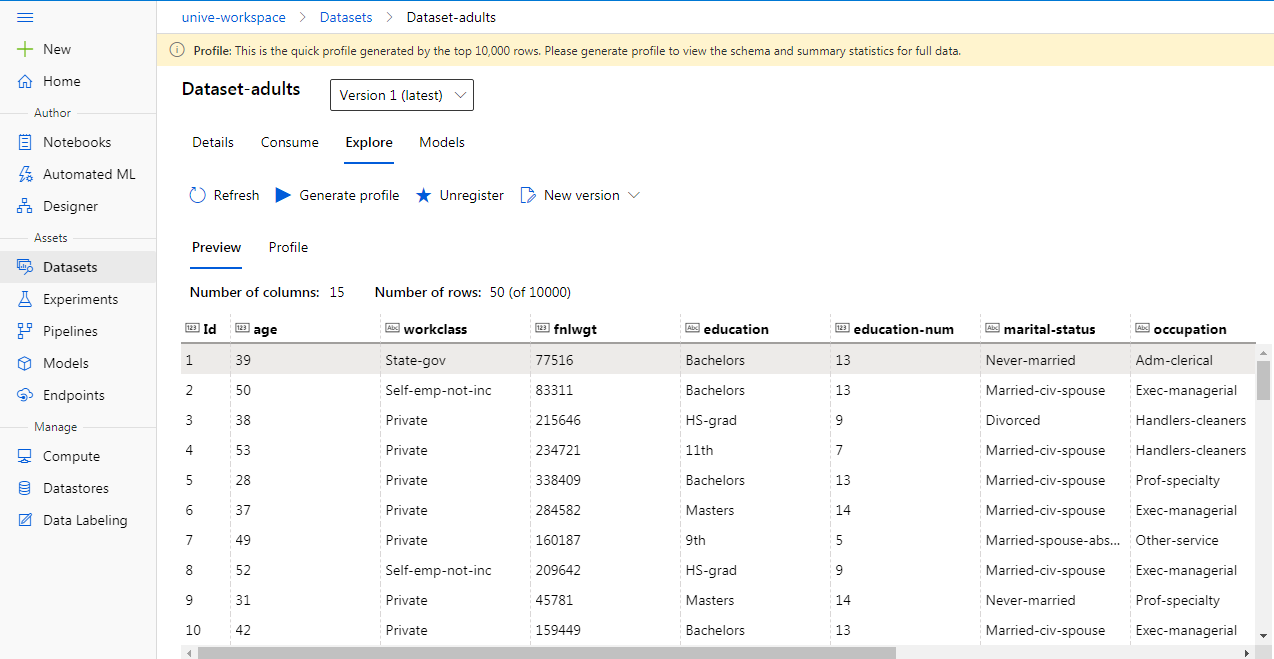

In [10]:
Image(filename='images/Azure/Exp-2/SVC/dataset.png')

## Designer

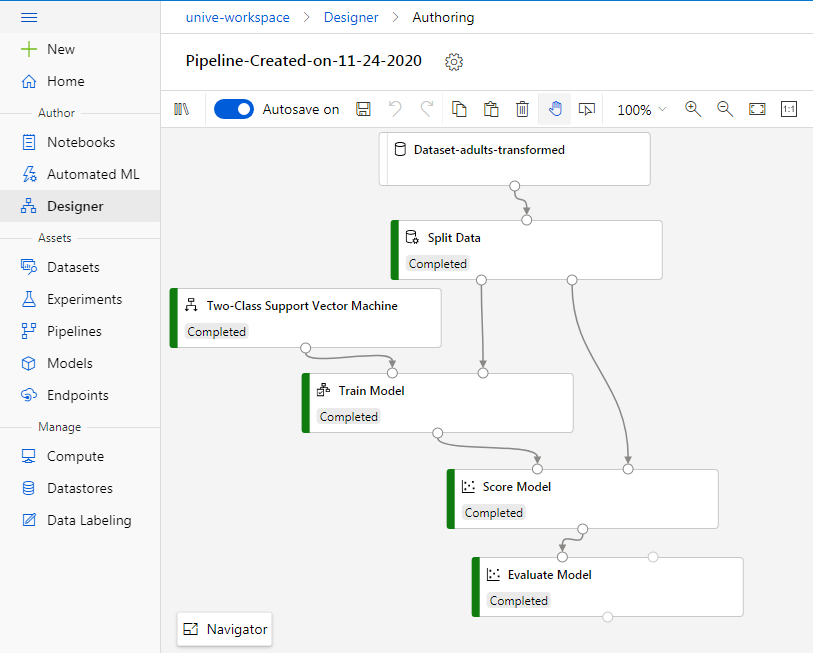

In [11]:
from IPython.display import Image
Image(filename='images/Azure/Exp-2/SVC/0-pipeline.png')

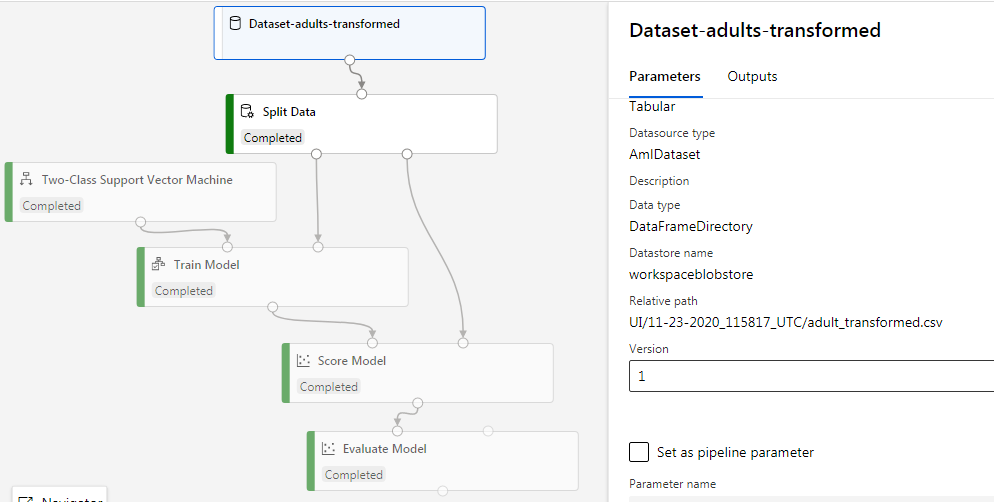

In [12]:
Image(filename='images/Azure/Exp-2/SVC/1-dataset.png')

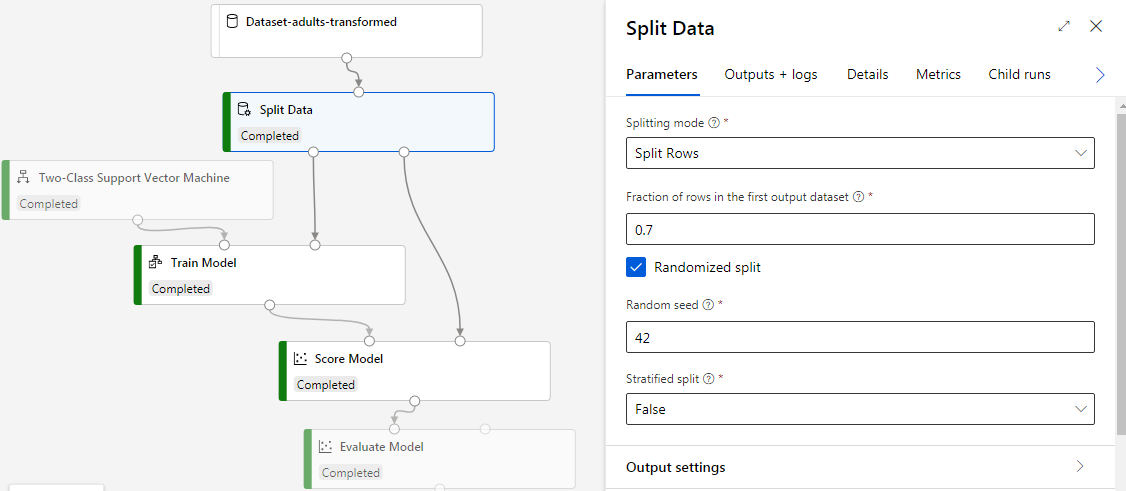

In [13]:
Image(filename='images/Azure/Exp-2/SVC/2-split.png')

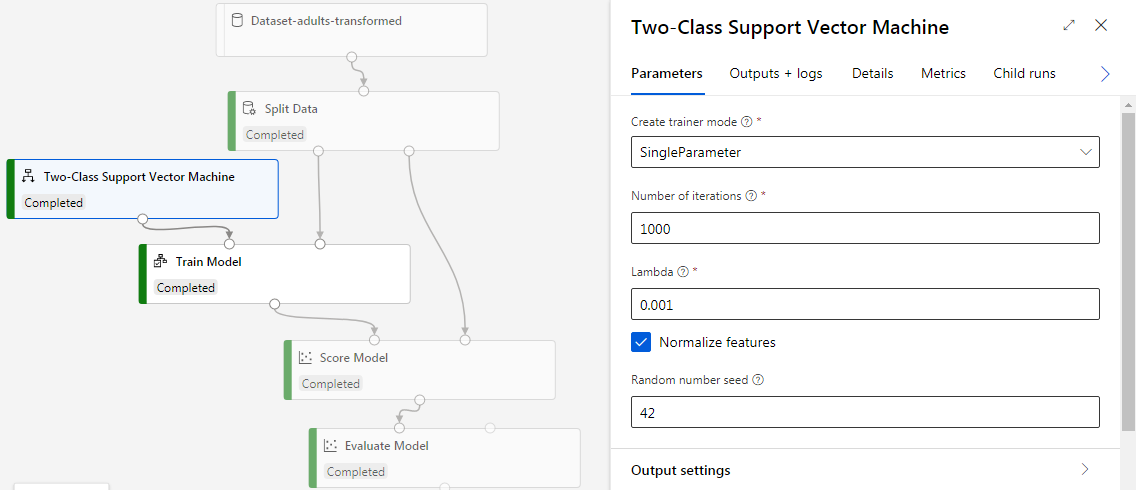

In [14]:
Image(filename='images/Azure/Exp-2/SVC/3-classify.png')

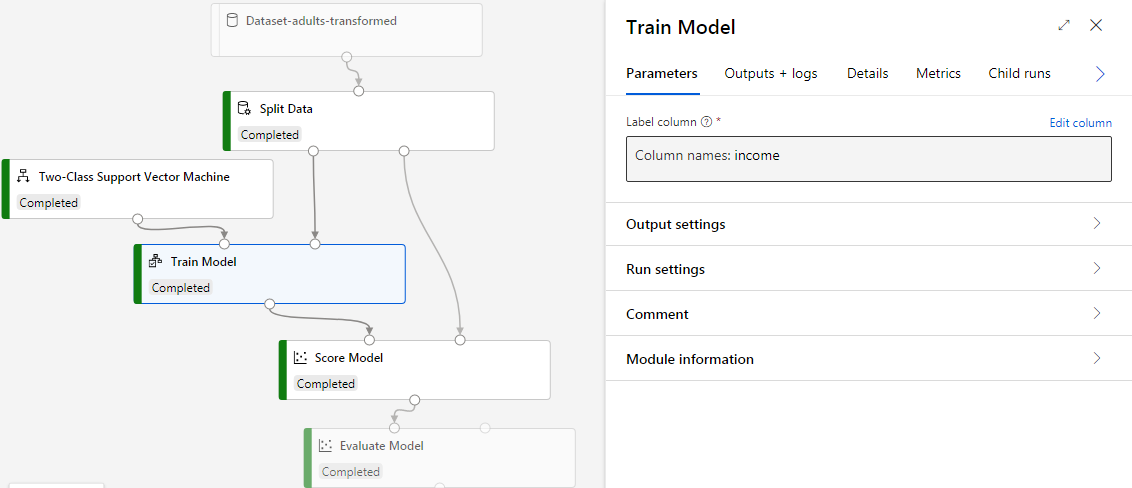

In [15]:
Image(filename='images/Azure/Exp-2/SVC/4-train-model.png')

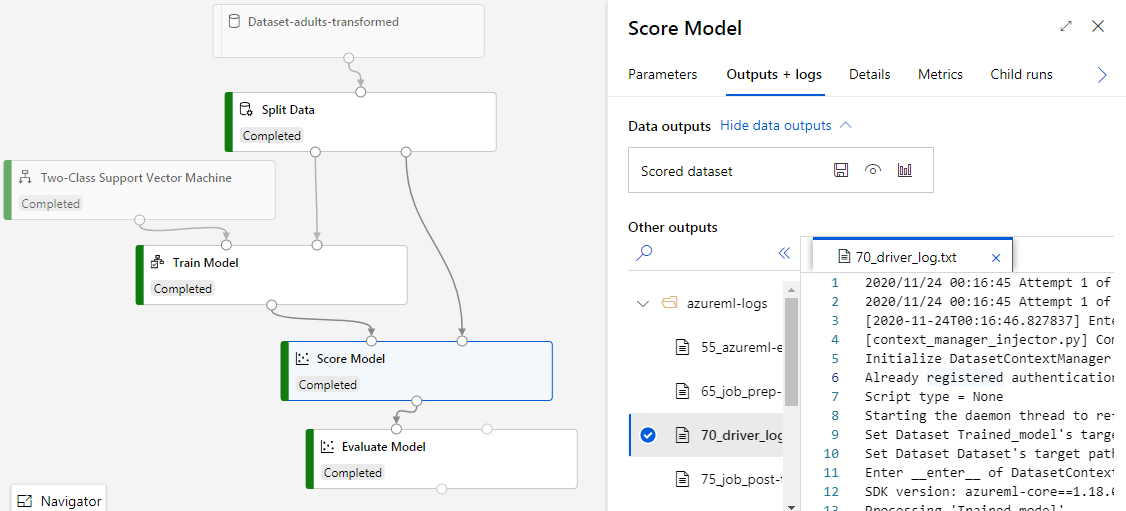

In [16]:
Image(filename='images/Azure/Exp-2/SVC/5-score-model.png')

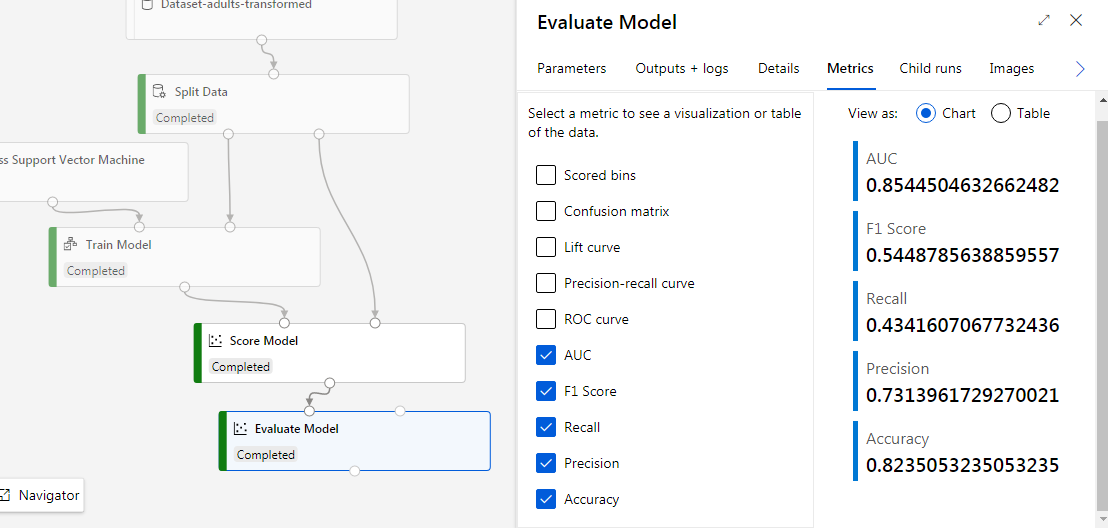

In [17]:
Image(filename='images/Azure/Exp-2/SVC/6-evaluate-model.png')

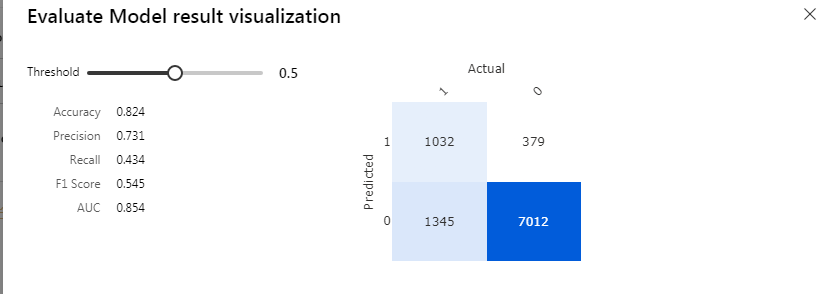

In [18]:
Image(filename='images/Azure/Exp-2/SVC/designer-metrics.png')

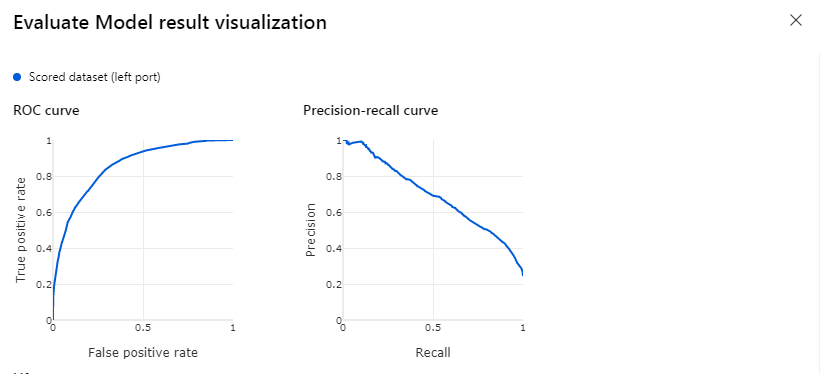

In [19]:
Image(filename='images/Azure/Exp-2/SVC/designer-metrics-2.png')

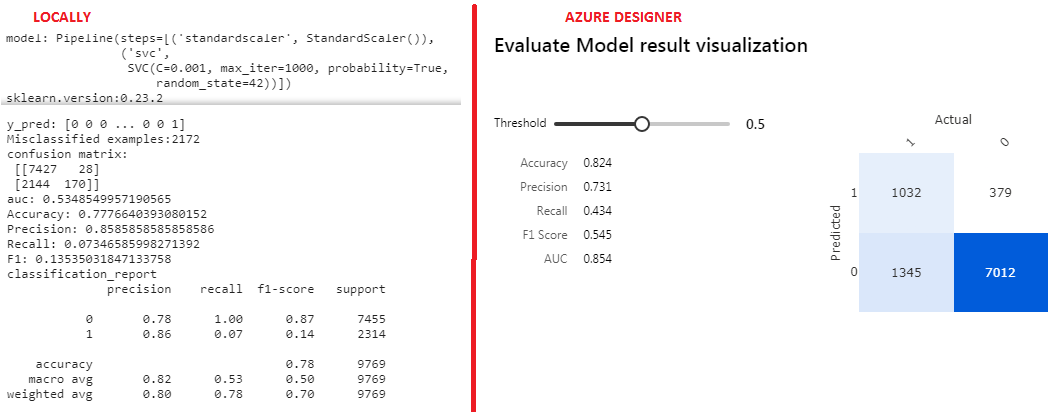

In [20]:
Image(filename='images/Azure/Exp-2/SVC/result2.png')